# 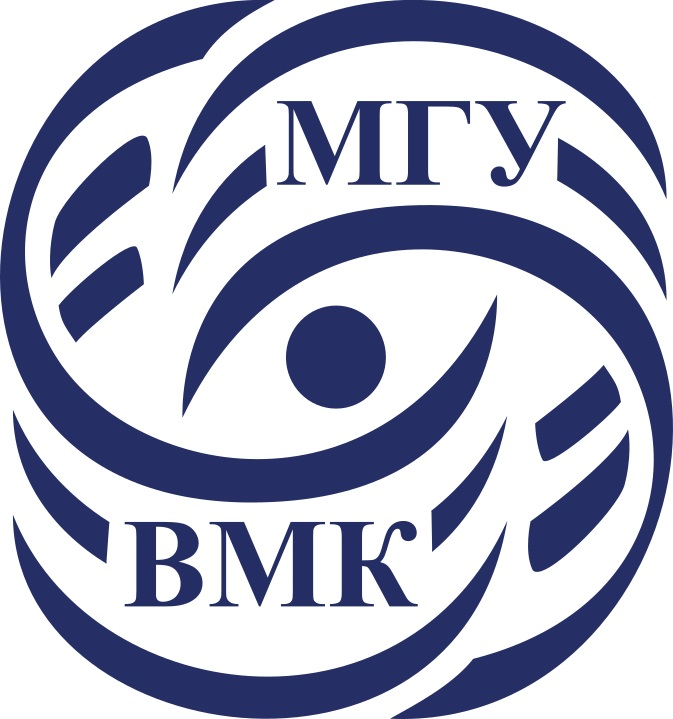

# Машинное обучение. ВМК МГУ

# Практическое задание 9: Случайные леса и отбор признаков
## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

__В этом задании вы:__

- Посмотрите, как выращивают случайные леса
- Проверите подвержены ли случайные леса переобучению
- Узнаете базовые методы отбора признаков

-------
<font color="white" style="opacity:0.2024"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [1]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r /content/requirements_2024_25_for_colab_small.txt

Downloading...
From: https://drive.google.com/uc?id=10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
To: /content/requirements_2024_25_for_colab_small.txt
100% 375/375 [00:00<00:00, 972kB/s]


Проверим версию библиотеки:

In [80]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2024"></font>

Привет, ребятушки!

Сегодня мы с вами посмотрим на такую вещь, как случайные леса. Мы попытаемся понять принцип их работы, пощупать, исследовать влияние параметров и, самое главное, узнаем, какое свойство случайных лесов оказало сильное влияние на машинное обучение.

Хочу обратить внимание, что в этом задании мы будем работать с регрессорами, однако все сделанные нами выводы верны также и для задач классификации.

<font color='OrangeRed'>**Внимание!**</font> Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка). Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

Для вычисления MAE можно использовать встроенную функцию `sklearn.metrics.mean_absolute_error`

Импортируем необходимые библиотеки:

In [81]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline # Если забыли, загляните в ноутбук Sklearn-knn-normalize-cv
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

#####
# если Вы не различаете предлагаемые цвета, то Вы можете раскомментить строку ниже
# для применения специальной цветовой палитры или аналогичных
# plt.style.use('tableau-colorblind10')
#####

import numpy as np

import time
import os

from itertools import combinations

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Загрузим датасет со стоимостью недвижимости в Калифорнии, который нам понадобится для первых заданий:

In [82]:
def get_california_dataset():
    """Return the splits of the California housing dataset for training and testing"""
    X, y = fetch_california_housing(return_X_y=True)
    return train_test_split(X, y, random_state=42)

X_train, X_test, y_train, y_test = get_california_dataset()

# Случайные леса

Как многие из вас уже знают, [теорема Кондорсе о присяжных](https://neerc.ifmo.ru/wiki/index.php?title=%D0%92%D0%B8%D0%B4%D1%8B_%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B9#.D0.A2.D0.B5.D0.BE.D1.80.D0.B5.D0.BC.D0.B0_.D0.9A.D0.BE.D0.BD.D0.B4.D0.BE.D1.80.D1.81.D0.B5_.D0.BE_.D0.BF.D1.80.D0.B8.D1.81.D1.8F.D0.B6.D0.BD.D1.8B.D1.85), гласит, что если у нас имеется некоторое количество различных методов, каждый из которых предсказывает величину лучше, чем случайно, то голосование таких методов работает лучше, чем любой из этих методов по отдельности.

Данная идея отлично ложится на деревья решений. В теории для повышения дисперсии предсказаний каждого отдельного дерева можно ограничивать их глубину. На практике, помимо этого, также хорошо себя показало использование ограниченного набора признаков и данных. Это приводит нас к идее случайных лесов, о которых вы узнали на занятии.


### <font color='DarkOrange'>**Задание 1 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии   
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить 3 дерева решений, для каждого при инициализации установить `random_state` равный 1, 2 и 3. Ограничивать глубину деревьев не нужно.
1. Получить предсказание для тестовой выборки от каждого регрессора, а также получить ``усреднённое`` предсказание.
1. Посчитать MAE для каждого из деревьев, полученных в первом пункте, а также для усреднённых предсказаний. Сделать вывод о том, стало лучше или нет.

In [83]:
# Обучаем деревья
dt1 = DecisionTreeRegressor(random_state=1)
dt2 = DecisionTreeRegressor(random_state=2)
dt3 = DecisionTreeRegressor(random_state=3)

dt1.fit(X_train, y_train), dt2.fit(X_train, y_train), dt3.fit(X_train, y_train)

# Получаем предсказания на тестовой выборке
y_pred1 = dt1.predict(X_test)
y_pred2 = dt2.predict(X_test)
y_pred3 = dt3.predict(X_test)

# Получаем усредненное предсказание
avg_prediction = np.mean([y_pred1, y_pred2, y_pred3], axis=0)

# Вычисляем MAE
print(f"MAE для 1 дерева: {round(mean_absolute_error(y_test, y_pred1), 2)}\n")
print(f"MAE для 2 дерева: {round(mean_absolute_error(y_test, y_pred2), 2)}\n")
print(f"MAE для 3 дерева: {round(mean_absolute_error(y_test, y_pred3), 2)}\n")
print(f"MAE для усредненного предсказания по всем деревьям: {round(mean_absolute_error(y_test, avg_prediction), 2)}\n")

MAE для 1 дерева: 0.46

MAE для 2 дерева: 0.46

MAE для 3 дерева: 0.46

MAE для усредненного предсказания по всем деревьям: 0.45



<font color='MediumOrchid'>**Ваш ответ тут:**</font> Видно, <u>что ошибка для усредненного предсказания уменьшилась</u>, что говорит о том, что **усреднение улучшает предсказания отдельно взятых деревьев**.

Разные `random_state` позволяют моделям строить немного разные деревья, это может помочь повысить устойчивость модели, действуя как сглаживание.

---

Надеюсь, мы смогли убедиться, что это хоть немного, но работает. Правда, улучшение достаточно маленькое и для прорыва в машинном обучении этого еще недостаточно.

А что влияет на улучшение, которое мы получаем при использовании ансамбля методов? Соответствующая теорема дает достаточно простой ответ: различность методов и ведет к улучшению. Если у нас есть много методов, предсказания которых отличаются незначительно, то их усреднение практически ничего не изменит. Если же у нас есть множество достаточно разных методов, то и их усреднение будет отличаться от предсказаний каждого отдельного метода. Видимо, random_state было недостаточно. Как же нам еще сильнее увеличить различность методов? Ответ вы знаете: использовать случайные признаки и случайную выборку объектов. Это приводит нас к случайным лесам, но с одним уточнением - случайные признаки отбираются не для отдельного дерева, а для конкретной вершины.

### <font color='DarkOrange'>**Задание 1.2 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии    
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучить `RandomForestRegressor`. Для честности следует установить ``n_estimators=3``, то есть сделать число деревьев равным 3 (как мы сделали в предыдущем задании). Для однородности также поставьте ``random_state = 0``
1. Посчитать MAE полученных предсказаний. Сравнить их с результатами, полученными в предыдущем пункте. Сделайте вывод.

In [84]:
# Обучаем RandomForestRegressor
rf = RandomForestRegressor(n_estimators=3, random_state=0)

rf.fit(X_train, y_train)

# Предсказание и оценка
y_pred_rf = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)

print(f"(RandomForestRegressor) MAE: {round(rf_mae, 2)}\n")

(RandomForestRegressor) MAE: 0.39



**<font color='MediumOrchid'>Вывод по результату</font>**: `Случайный лес` <u>выдал меньшую ошибку</u>, чем **усреднение предсказаний деревьев** и **предсказания отдельно взятых деревьев**.

Так как мы знаем, что в **лесу реализовано обучение каждого дерева на случайной подвыборке данных** и для <u>**каждого дерева отбирается случайных поднабор признаков**</u> при каждом разбиении.

Тем временем, когда происходит обучение ***трех отдельных деревьев***, то каждое <u>предсказание независимо</u>, а также они не взаимодействуют между собой, поэтому усреднение работает как <u>**простая комбинация независимых моделей**</u>, из-за чего ошибка уменьшается не сильно.

---

Давайте изучим влияние числа деревьев на результат предсказаний.

### <font color='DarkOrange'>**Задание 1.3 [2 балла]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучите 10 случайных лесов, установив random_state=42 и замерив время, потраченное на обучение. Для обучаемых лесов, используйте число деревьев (`n_estimators`) из `np.logspace(1, 3, num=10)` (округлите значения вниз до целых чисел). Таким образом мы получим оценку результата для лесов, построенных с различным числом деревьев.
1. Для всех 10 лесов посчитайте MAE на тренировочном и тестовом множествах.
1. Постройте график для отображения зависимости времени обучения от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите время, потраченное на обучение.
1. Постройте еще один график для отображения зависимости значения MAE от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите одним цветом значение MAE на тренировочном множестве, другим цветом MAE на тестовом множестве.
1. Проанализируйте результаты и графики, сделайте выводы про время обучения при различном числе деревьев и про качество результатов (в частности - переобучение)

In [85]:
# Заводим количество деревьев
n_estimators_values = np.floor(np.logspace(1, 3, num=10)).astype(int)

# Заведем списки ошибок
train_maes, test_maes, training_times = [], [], []

# Начало обучени и фиксирования результатов разных лесов с различным числом деревьев, также округляем число деревьев вниз до целых чисел
for n in n_estimators_values:
  model = RandomForestRegressor(n_estimators=2, random_state=42)

  # Начинаем замер времени обучения
  start_time = time.time()
  model.fit(X_train, y_train)
  end_time = time.time()

  # Сохранение результатов
  training_times.append(end_time - start_time)
  train_maes.append(mean_absolute_error(y_train, model.predict(X_train)))
  test_maes.append(mean_absolute_error(y_test, model.predict(X_test)))

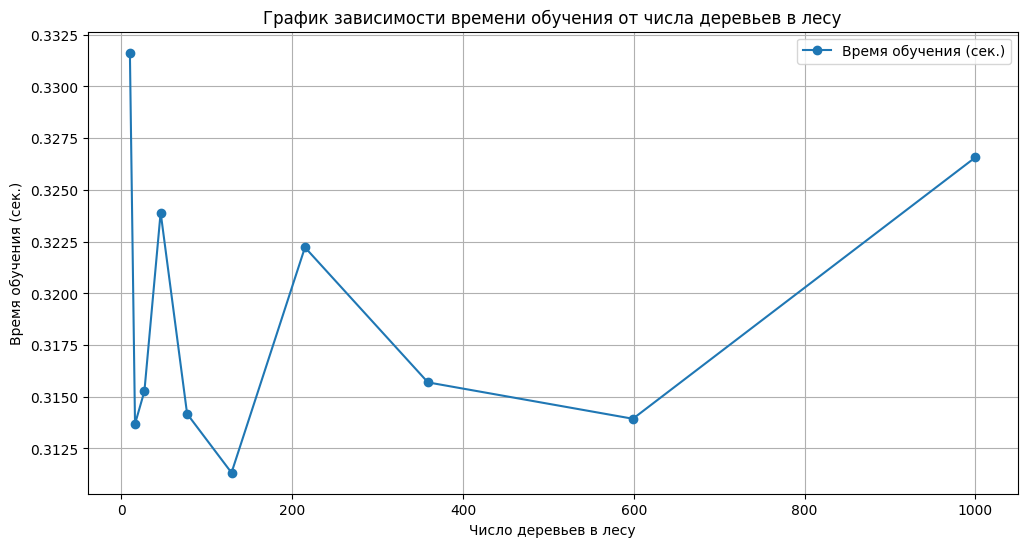

In [86]:
# Визуализация графика зависимости времени обучения от числа деревьев в лесу
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_values, training_times, marker='o', label="Время обучения (сек.)")
plt.xlabel("Число деревьев в лесу")
plt.ylabel("Время обучения (сек.)")
plt.title("График зависимости времени обучения от числа деревьев в лесу")
plt.grid(True)
plt.legend()
plt.show()

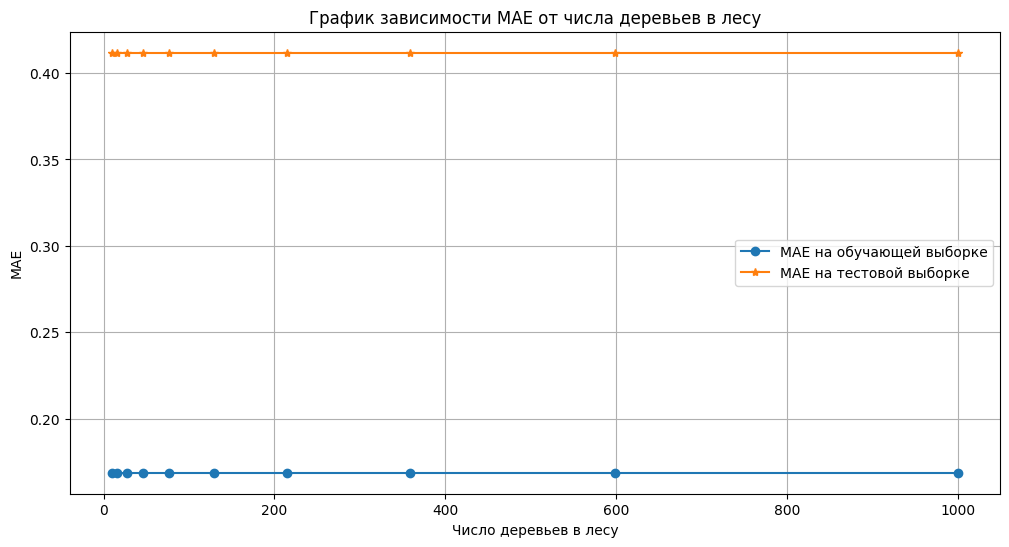

In [87]:
# Визуализация графика зависимости MAE от количества деревьев в лесу
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_values, train_maes, marker='o', label="MAE на обучающей выборке")
plt.plot(n_estimators_values, test_maes, marker='*', label="MAE на тестовой выборке")
plt.xlabel("Число деревьев в лесу")
plt.ylabel("MAE")
plt.title("График зависимости MAE от числа деревьев в лесу")
plt.grid(True)
plt.legend()
plt.show()

**<font color='MediumOrchid'>Вывод по результату</font>**: Из графиков видно, что при <u>увеличении числа деревьев</u> **время обучения растет**, а <u>**ошибка остается на том же уровне**</u>.

Оно конечно колеблеся от разного числа деревьев с 0 до 600, Сначала резко падает, затем резко возрастает, после 200 плавно снижается до 600 и затем начинает повышаться.

Причем заметно **видно переобучение**, <u>ошибка на обучающей выборке меньше, чем на тестовой</u> и она не меняется при увеличении числа деревьев.

Соответственно можно сделать вывод о том, что чем больше деревьев в лесу, тем выше риск переобучения, так как <u>деревья сильно подстраиваются под данные</u> и выдают неточный результат, а время работы при этом увеличивается.

В частности, после числа деревьев равному `600`, время обучения значительно увеличивается, но ошибка при этом не изменяется, что говорит о том, что <u>**лес не может выявить закономерности**</u>.



----

Как мы с вами знаем, случайный лес постепенно улучшает качество предсказаний, увеличивая число деревьев в ансамбле. А что если мы уже обучили лес, но хотим `нарастить` его, добавив несколько деревьев? Или если к нам пришли новые данные и мы хотим добавить деревьев, обученных на них, но не удалять деревья, построенные на предыдущих данных? Такой трюк возможен, и для этого следует использовать warm_start. То, как правильно использовать `warm_start` можно глянуть [тут](https://stackoverflow.com/questions/42757892/how-to-use-warm-start/42763502)

### <font color='DarkOrange'>**Задание 1.4 [2 балла]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Создайте случайный лес со следующими параметрами: `n_estimators = 100, warm_start = True, random_state=42`
2. Обучите полученный лес, засекая время, потраченное на обучение, и измерив качество предсказания на тесте по MAE
3. Увеличьте число деревьев в лесу. Для этого увеличьте число `regressor.n_estimators` на 100.
4. Воспользуйтесь методом `fit`, чтобы дообучить новые деревья. Не забудьте замерить время и качество!
5. Повторяйте два предыдущих шага до тех пор, пока вы не вырастите лес с 1000 деревьями.
6. Постройте графики зависимости качества и времени обучения от количества деревьев (время считайте отдельно для каждого дообучения, без учета затрат на предыдущие итерации)
7. Проанализируйте результаты и графики, сделайте выводы про время обучения и качество, сравните с результатом из предыдущего пункта

In [74]:
# Зададим переменные, на которые будем увеличивать число дерево
initial_trees = 100
max_trees = 1000
increment = 100

# Создаем случайный лес
rf = RandomForestRegressor(n_estimators=initial_trees, warm_start=True, random_state=42)

# Списки для хранения результатов
n_estimators_values = []
training_times = []
train_maes = []
test_maes = []

# Обучаем лес, замеряем время обучение и считаем качество предсказания
start_time = time.time()
rf.fit(X_train, y_train)
end_time = time.time()

# Замер метрики и времени
training_times.append(end_time - start_time)
n_estimators_values.append(initial_trees)
train_maes.append(mean_absolute_error(y_train, rf.predict(X_train)))
test_maes.append(mean_absolute_error(y_test, rf.predict(X_test)))

In [75]:
# Увеличиваем число деревьев, сначала на 100, затем продолжаем увеличивать, пока не дойдем до 1000
for n in range(initial_trees + increment, max_trees + 1, increment):
  rf.n_estimators = n
  start_time = time.time()
  rf.fit(X_train, y_train)
  end_time = time.time()

  n_estimators_values.append(n)
  training_times.append(end_time - start_time)
  test_maes.append(mean_absolute_error(y_test, rf.predict(X_test)))

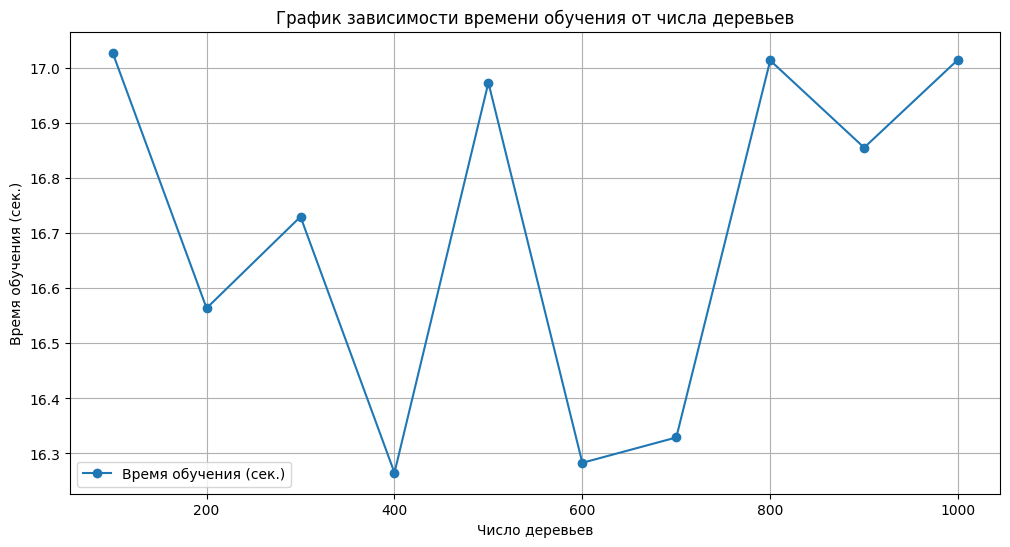

In [76]:
# График зависимости времени обучения от кол-ва деревьев
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_values, training_times, marker='o', label='Время обучения (сек.)')
plt.xlabel("Число деревьев")
plt.ylabel("Время обучения (сек.)")
plt.title("График зависимости времени обучения от числа деревьев")
plt.grid(True)
plt.legend()
plt.show()

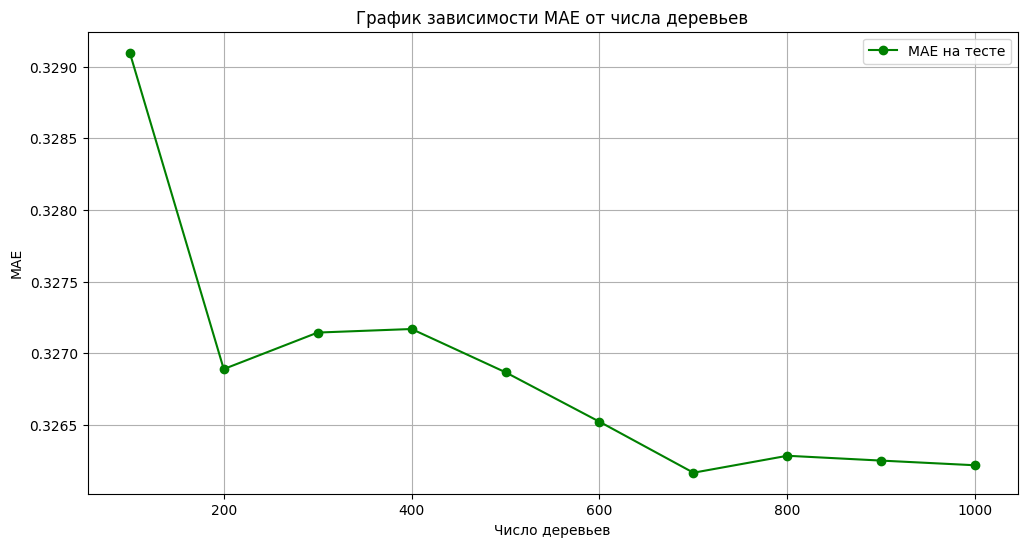

In [77]:
# График зависимости MAE на тесте от кол-ва деревьев
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_values, test_maes, marker='o', color='green', label='MAE на тесте')
plt.xlabel("Число деревьев")
plt.ylabel("MAE")
plt.title("График зависимости MAE от числа деревьев")
plt.grid(True)
plt.legend()
plt.show()

**<font color='MediumOrchid'>Вывод по результату</font>**: Видно, что графики уже разные и что **время обучения плавно снижается** сначало до `200` числа деревьев, но продолжает колебаться, но уже более равномернее, после `600` деревьев происходит **заметное увеличение времени обучения**, но  после `800` деревьев опять происходит снижение к `900` деревьям и далее...

Но в то время, **ошибка на тесте плавно уменьшается** с <u>увеличением числа деревьем</u>, что может порадовать, поскольку с предыдущим результатом наблюдалось значительное переобучение.

Можно сделать вывод, что т**рюк с дообучением деревьев** действительно работает, то есть мы <u>наращиваем новые деревья, но при этом не забываем про предыдущие</u>, что позволяет **учесть их прогресс внесения предсказаний в модели**, тем самым меняя время обучения, что и видно на графике, что оно *плавно сначала уменьшается*, затем мы добавили деревьев, оно увеличивается, тем ***самым ускоряя время обучения*** и т.д. по мере наращивания деревьев в лесу, а `MAE` при этом после **200** деревьев слегка увеличилась и после **400** начинает плавно уменьшаться, впоследствии она увеличивается незначительно.

Мы получаем, что нас **лес состоит из разных деревьев**, <u>обученных на разных порциях данных</u>, что позволяет повысить точность предсказания, что и наблюдается на графике.

# Отбор признаков

Теперь переключимся на несколько иную задачу. Представим, что нам нужно не только обучить какой-то метод, но и выделить наиболее полезные признаки (или, как минимум, удалить шумовые). Как мы можем это сделать? На самом деле, в машинном обучении есть просто огромное количество способов отбора признаков, и сейчас мы познакомимся с самимы популярными из них.

### L1 регуляризация

Как вы уже узнали из лекций, регуляризация помогает делать процесс обучения более робастным. Однако у L1 регуляризации есть один побочный эффект - она также способна занулять наименее информативные признаки. Давайте проверим этот эффект на практике.

### <font color='DarkOrange'>**Задание 2.1 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучите три линейных классификатора с L1 регуляризацией (`linear_model.Lasso`). Установите коэффициенты регуляризации `alpha` равными `0.1, 0.2 и 0.5.` Перед подачей признаков в Lasso, `нормализуйте признаки` (MinMax или StandardScaler на ваш выбор).
1. Обучите данные классификаторы на обучающем множестве.
1. Замерьте их качество на тесте, а также выведите количество ненулевых коэффициентов. Коэффициенты обученной линейной регрессии можно получить при помощи аттрибута `.coef_`
1. Выведите признаки, которые были занулены. Имена признаков можно найти в fetch_california_housing().feature_names
1. Сделайте выводы о способности LASSO отбирать признаки

In [15]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Инициализируем классификаторы
l1_cls1 = Lasso(alpha=0.1)
l1_cls2 = Lasso(alpha=0.2)
l1_cls3 = Lasso(alpha=0.5)

# Инициализируем scaler
scaler = StandardScaler()

# Нормализуем признаки
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучаем классификаторы на нормализованных признаках
l1_cls1.fit(X_train_scaled, y_train)
l1_cls2.fit(X_train_scaled, y_train)
l1_cls3.fit(X_train_scaled, y_train)

# Замер качества на тесте
y_pred1 = l1_cls1.predict(X_test_scaled)
y_pred2 = l1_cls2.predict(X_test_scaled)
y_pred3 = l1_cls3.predict(X_test_scaled)

print(f"(Lasso1) MAE: {round(mean_absolute_error(y_test, y_pred1), 2)}\n")
print(f"(Lasso2) MAE: {round(mean_absolute_error(y_test, y_pred2), 2)}\n")
print(f"(Lasso3) MAE: {round(mean_absolute_error(y_test, y_pred3), 2)}\n")

(Lasso1) MAE: 0.62

(Lasso2) MAE: 0.66

(Lasso3) MAE: 0.76



In [23]:
# Получим количество ненулувых коэффицентов
l1_count = list(l1_cls1.coef_).count(0)
l2_count = list(l1_cls2.coef_).count(0)
l3_count = list(l1_cls3.coef_).count(0)

# Выведем количество ненулевых коэффицентов
print(f"Коэффиценты Lasso1: \n{l1_cls1.coef_}\n Кол-во зануленных коэффицентов: {l1_count}\n\n")
print(f"Коэффиценты Lasso2: \n{l1_cls2.coef_}\n Кол-во зануленных коэффицентов: {l2_count}\n")
print(f"Коэффиценты Lasso3: \n{l1_cls3.coef_}\n Кол-во зануленных коэффицентов: {l3_count}\n")

Коэффиценты Lasso1: 
[ 0.70728992  0.10446245 -0.          0.         -0.         -0.
 -0.01040421 -0.        ]
 Кол-во зануленных коэффицентов: 5


Коэффиценты Lasso2: 
[ 0.59553092  0.         -0.         -0.         -0.         -0.
 -0.         -0.        ]
 Кол-во зануленных коэффицентов: 7

Коэффиценты Lasso3: 
[ 0.29553092  0.          0.         -0.         -0.         -0.
 -0.         -0.        ]
 Кол-во зануленных коэффицентов: 7



In [25]:
# Выведем названия признаков

fetch_california_housing().feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [28]:
# Выведем обнуленные для каждого классификатора

zeroed_features1 = np.array(fetch_california_housing().feature_names)[l1_cls1.coef_ == 0]
zeroed_features2 = np.array(fetch_california_housing().feature_names)[l1_cls2.coef_ == 0]
zeroed_features3 = np.array(fetch_california_housing().feature_names)[l1_cls3.coef_ == 0]

print(f"Обнуленные признаки Lasso1: {zeroed_features1}\n")
print(f"Обнуленные признаки Lasso2: {zeroed_features2}\n")
print(f"Обнуленные признаки Lasso3: {zeroed_features3}\n")

Обнуленные признаки Lasso1: ['AveRooms' 'AveBedrms' 'Population' 'AveOccup' 'Longitude']

Обнуленные признаки Lasso2: ['HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup' 'Latitude'
 'Longitude']

Обнуленные признаки Lasso3: ['HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup' 'Latitude'
 'Longitude']



**<font color='MediumOrchid'>Вывод по результату</font>**: Видно, что `Lasso1` занулил 5 признаков, `Lasso2` 7 признаков, оставив лишь один ненулевой коэффициент, `Lasso3` занулил те же 7 признаков, однако коэффицент стад еще меньше, что указывает на более сильную регуляризацию.

`Lasso1` выдал лучшее качество при умеренном числе зануленных признаков, по сравнению с двумя другими, что говорит о том, что подбор оптимального `alpha` очень важен.

`Lasso` эффективно выполняет отбор признаков, обнуляя коэффиценты малозначимых, однако надо быть очень осторожным с регуляризацией, так как если неаккуратно усилить ее, то это может привести к потере ключевых признаков и ухудшению качества модели.

Отлично! Мы убедились, что при помощи L1 регуляризации можно отбирать наиболее информативные признаки. Такой же трюк можно применять к svm, который может занулить признак, если ни один опорный объект не использует его.

Как мы помним, при помощи линейных классификаторов можно ранжировать признаки по важности, воспользовавшись соответствующими коэффициентами. Но перед этим нужно нормализовать используемые признаки, иначе значения коэффициентов невозможно будет сравнивать между собой.

Мы не зря начали данное задание со случайных лесов. Случайные леса также могут оценивать важность признаков! У каждого обученного леса есть аттрибут `feature_importances_.` Эти оценки рассчитываются на основе уменьшения критерия качества (например, Джини для классификации или среднеквадратичной ошибки для регрессии) при разделении узлов дерева на основе каждого признака. Чем сильнее увеличивается качество при использовании признака - тем он важнее.

 Данные значения уже отнормализованы и их можно использовать в явном виде для оценки важности признаков! Давайте воспользуемся этим.

### <font color='DarkOrange'>**Задание 2.2 [1 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучите один случайный лес, установив`n_estimators=100`.
1. При помощи `rf.feature_importances_` найдите три признака, которые являются наиболее важными, а также три наименее важных признака. Выведите их названия.
1. Обучите обычную линейную регрессию `LinearRegressio`n на всех признаках, а также только на отобранных случайными лесами признаках. Не забывайте, что перед использованием линейной регрессии признаки нужно `отнормализовать`!

1. Сравните качество предсказаний и сделайте вывод о качестве выделенных признаков. Сравните с признаками, выделенными через LASSO.

In [33]:
# Обучаем случайный лес
rf = RandomForestRegressor(n_estimators=100)

rf.fit(X_train, y_train)

# Найдем наименеее важные и наименее важные признаки
feature_importances = pd.Series(rf.feature_importances_, index=fetch_california_housing().feature_names)

top_features = feature_importances.nlargest(3).index.tolist()
bottom_features = feature_importances.nsmallest(3).index.tolist()

print(f"Три наиболее важных признака: {top_features}")
print(f"Три наименне важных признака: {bottom_features}")

Три наиболее важных признака: ['MedInc', 'AveOccup', 'Latitude']
Три наименне важных признака: ['AveBedrms', 'Population', 'AveRooms']


In [34]:
# Обучение линейной регрессии на всех данных
lr_all = LinearRegression()
lr_all.fit(X_train_scaled, y_train)

LinearRegression()

In [41]:
# Отфильтруем важные признаки, чтобы их подать на вход модели
X_train_df = pd.DataFrame(X_train, columns=fetch_california_housing().feature_names)
X_test_df = pd.DataFrame(X_test, columns=fetch_california_housing().feature_names)

X_train_top = X_train_df[top_features]
X_test_top = X_test_df[top_features]

In [42]:
# Обучим линейную регрессию только на отобранных признаках
X_train_top_scaled = scaler.fit_transform(X_train_top)
X_test_top_scaled = scaler.transform(X_test_top)

In [43]:
lr_top = LinearRegression()
lr_top.fit(X_train_top_scaled, y_train)

LinearRegression()

In [46]:
# Сравним качество
mae_all = mean_absolute_error(y_test, lr_all.predict(X_test_scaled))
mae_top = mean_absolute_error(y_test, lr_top.predict(X_test_top_scaled))

print(f"MAE на всех признаках: {mae_all:.2f}")
print(f"MAE на важных признаках: {mae_top:.2f}")

MAE на всех признаках: 0.53
MAE на важных признаках: 0.62


**<font color='MediumOrchid'>Вывод по результату</font>**: По результатам видно, что `линейная регрессия нав всех признаках` показала наилучшее качество, чем `регрессия на наиболее важных признаках`, что говорит о том, что модель откинула признаки, которые какой то свой вес в предсказание вносили, т.е. упустиоа значимые переменные.

Случайный лес показал, что три наиболее важных признака это: **'MedInc', 'AveOccup', 'Latitude'**, во всех Lasso и вправду не обнуляется признак `MedInc`, что говорит о том, что этот признак действительно значимый. А вот `AvOccup` и `Latitude` уже отбрасываются второй и третьей моделями, что ставит под сомнение их значимость, так как лес посчитал их наиболее важными.

Либо можно сделать вывод о том, что **случайный лес** и **Lasso** имеют разные подходы по отбору признаков. **Lasso** зануляет коэффициенты, что полезно при сильной коррелированности признаков, а **случайный лес** оценивает признаки по их вкладу в уменьшение ошибки, что полезно при нелинейных зависимостях.

То есть, можно заключить, что между несоответствующими признаками у `Lasso` и `RandomForest` есть разная связь.

---

До сих пор мы отбирали признаки по принципу удаления наименее информативных. Однако к данной задаче можно подойти с другого конца - добавлять признаки по 1, выбирая наиболее информативный из тех, что мы еще не использовали. Давайте посмотрим, что мы получим при помощи такой стратегии.

Кратко, данную стратегию можно описать следующим псевдокодом:

1. Инициализировать список выбранных признаков (пустой)  
2. Инициализировать список оставшихся признаков (все доступные)  
3. Пока выбранное число признаков меньше необходимого:  
   3.1 Для каждого признака из оставшихся:  
      - Добавить его к текущему списку выбранных  
      - Обучить модель на этих признаках  
      - Вычислить ошибку на тестовых данных  
      
   3.2 Добавить признак с наименьшем значением ошибки в пункте 3.1 в список выбранных

   3.3 Удалить его из списка оставшихся  

4. Вернуть список лучших признаков  


### <font color='DarkOrange'>**Задание 2.3 [2 балл]**</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Реализуйте процесс отбора признаков путем добавление одного наиболее информативного признака. Воспользуйтесь `DecisionTreeRegressor` в качестве базового классификатора.
1. Отберите 3 наиболее важных признака
1. Обучите обычную линейную регрессию на всех признаках, а также только на отобранных признаках. Сравните качество предсказаний и сделайте вывод о качестве выделенных признаков. Сравните с признаками, выделенными в предыдущем задании.

In [54]:
def select_best_features(X_train, X_test, y_train, y_test, max_features=3):
    best_features = []

    # Доступные признаки, те что остались
    remaining_features = list(range(X_train.shape[1]))
    for _ in range(max_features):
      best_feature = None
      best_mae = float('inf')

      for feature in remaining_features:
        selected_features = best_features + [feature]

        # Обучаем DecisionTreeRegressor
        model = DecisionTreeRegressor(random_state=42)
        model.fit(X_train[:, selected_features], y_train)

        # Оценка качества
        y_pred = model.predict(X_test[:, selected_features])
        mae = mean_absolute_error(y_test, y_pred)

        if mae < best_mae:
          best_mae = mae
          best_feature = feature

      best_features.append(best_feature)
      remaining_features.remove(best_feature)

    selected_feature_names = [fetch_california_housing().feature_names[i] for i in best_features]

    return selected_feature_names

In [55]:
# Отбираем три наиболее важных признака
best_features = select_best_features(X_train, X_test, y_train, y_test, max_features=3)
print(f"Выбранные признаки: {best_features}")

Выбранные признаки: ['Longitude', 'Latitude', 'MedInc']


In [58]:
# Обучаем регрессию на всех данных и на отобранных признаках

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Индексы выбранных признаков
best_feature_indices = [fetch_california_housing().feature_names.index(f) for f in best_features]

X_train_best_scaled = scaler.fit_transform(X_train[:, best_feature_indices])
X_test_best_scaled = scaler.transform(X_test[:, best_feature_indices])

# Линейная регрессия на всех признаках
lr_all = LinearRegression().fit(X_train_scaled, y_train)
mae_all = mean_absolute_error(y_test, lr_all.predict(X_test_scaled))

# Линейная регрессия на выбранных признаках
lr_best = LinearRegression().fit(X_train_best_scaled, y_train)
mae_best = mean_absolute_error(y_test, lr_best.predict(X_test_best_scaled))

print(f"MAE на всех признаках: {mae_all:.2f}")
print(f"MAE на выбранных признаках: {mae_best:.2f}")

MAE на всех признаках: 0.53
MAE на выбранных признаках: 0.55


**<font color='MediumOrchid'>Вывод по результату</font>**: Видно, что при таком отборе признаков качество **регрессии на выбранных признаках заметно улучшилось** и стало почти таким же, как у **регрессии всех признаках**.

То есть, **процесс отбора признаков путем добавления одного наиболее информативного признака** позволил улучшить качество, так как он проверяет ***качество на каждом признаке*** и сравнивает с другими, тем самым позволяя сохранить ключевые переменные.

По сравнению с предыдущими заданиями, есть схожесть, признак `MedInc` остается значимым, `Latitude` выделяется, так как `Lasso1` и `RandomForest` посчитали его значимым, а также выделяется еще признак `Longitude`, <u>который обнуляется в каждой модели</u> `Lasso` и <u>который не включается в важные признаки `случайным лесом`</u>, но если посмотреть на качество, то видно, что после добавления этого признака <u>**оно стало самым лучшим**</u>, что говорит о том, что мы сохранили значимый признак, который якобы не выделялся моделями, и что неаккуратный отбор признаков может значительно приводить к ухудшению качества, поэтому очень важно не отметать и проверять внос каждого потенциального признака в качество модели.

Но справедливости ради нужно отметить, что качество на всех признаках незначительно лучше, что может говорить о том, то еще остались значимые признаки .